In [1]:
import copy
import pickle
import sys

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

import lieb_liniger_state as lls
import rho_form_factor as rff
from utils import map_to_entire_space, map_to_bethe_numbers
import sum_rule

np.random.seed(7)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
L = N = 5
Imax = 20

In [3]:
def all_unique(state):
    """Check if all entries of a state are unique."""
    if len(state) > len(set(state)):
        return False
    else:
        return True


def generate_all_legal_new_states(current_state, previous_states, max_I):
    """
    Generate all new legal states for the Lieb-Liniger model.

    Legal states are all those states derived from the current state
    that mutate one of the Bethe numbers by +/- 1, have only unique
    entries, and have not previously been visited.
    """
    legal_new_states = []
    for i, bethe_number in enumerate(current_state):
        for p in [-1, 1]:
            new_state = sorted(list(current_state[:i]) + list(current_state[i+1:]) + list([current_state[i] + p]))
            if all_unique(new_state) and new_state not in previous_states and not (np.abs(np.array(new_state)) > max_I).any():
                legal_new_states.append(new_state)

    return legal_new_states


def descent_tree(root_state, max_no_of_descents=10):
    already_explored = [root_state]
    deltas = []
    edges = [root_state]
    unexpanded = [root_state]
    no_edges = []
    for k in range(100):
        print(k)
        no_edges.append(len(edges))

        to_explore, delta = find_lowest_energy_delta(already_explored[-1], unexpanded)
        deltas.append(delta)
        already_explored.append(to_explore)
        print(already_explored)
        edges.remove(to_explore)
        unexpanded.remove(to_explore)
        descendants = generate_all_legal_new_states(to_explore, already_explored, Imax)
        for k in descendants:
            edges.append(k)
            unexpanded.append(k)

    print("plotting")
    plt.plot(range(100), no_edges)
    plt.show()

    return already_explored
    
def find_lowest_energy_delta(base, edges):
    # print("start")
    # print(base)
    energy_deltas = []
    N = len(edges[0])
    base_state = lls.lieb_liniger_state(1, L, N, base)
    base_state.calculate_all()
    base_energy  = base_state.energy
    # print("base", base_energy)
    lowest_energy_diff = 10000000000
    index = -1
    for i, k in enumerate(edges):
        state = lls.lieb_liniger_state(1, L, N, k)
        state.calculate_all()
        state_energy = state.energy
        # print("state", state_energy)
        diff = state_energy - base_energy
        # print("diff", diff)
        if diff < lowest_energy_diff:
            # print(k)
            lowest_energy_diff = diff
            # print(lowest_energy_diff)
            index = i
    return edges[index], lowest_energy_diff

In [ ]:
state = lls.lieb_liniger_state(1, L, 10)
already = descent_tree(list(state.Is), 1)
print(already)

In [ ]:
added_data = []
removed_data = []

for k in range(10000):
    if k % 100 == 0:
        print(k)
    rstate = lls.lieb_liniger_state(1, N, N, lls.generate_bethe_numbers(N, [], Imax))
    orig_bethe_map = map_to_entire_space(rstate.Is, Imax)
    rstate.calculate_all()
    adjacent_states = generate_all_legal_new_states(rstate.Is, [], Imax)

    ffs = {}
    for k in adjacent_states:
        lstate = lls.lieb_liniger_state(1, N, N, k)
        lstate.calculate_all()
        ff = rff.rho_form_factor(lstate, rstate)
        ffs[np.abs(ff*ff)] = lstate.Is

    removed_index = np.where(delta == -1)
    added_index = np.where(delta == 1)
    removed = np.zeros(2 * Imax + 1)
    added = np.zeros(2 * Imax + 1)

    np.put(removed, removed_index, 1)
    np.put(added, added_index, 1)
    
    added_data.append({"rstate": orig_bethe_map, "delta": added})
    removed_data.append({"rstate": orig_bethe_map, "delta": removed})

with open('removed.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(removed_data, f, pickle.HIGHEST_PROTOCOL)

with open('added.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(added_data, f, pickle.HIGHEST_PROTOCOL)

In [4]:
# define baseline model
def baseline_model(N):
    # create model
    model = Sequential()
    model.add(Dense(N, input_dim=N, activation='relu'))
    model.add(Dense(N, activation='relu'))
    model.add(Dense(N, activation='relu'))
    model.add(Dense(N**2, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def get_allowed_prediction(probs, state):
    """Only give non-zero probabilities to allowed transitions."""
    for i, k in enumerate(state):
        # Mask removals from unoccupied sites.
        if k == 0:
            for z in range(len(state)):
                probs[i][z] = 0
        # Mask additions to occupied sites.
        if k == 1:
            for z in range(len(state)):
                probs[z][i] = 0
    return probs / np.sum(probs)


def mutate(model, state, history):
    # print("Mutating")
    # print(state)
    probs = get_allowed_prediction(model.predict(state.reshape(1, -1)).reshape(2 * Imax + 1, 2 * Imax + 1), state)
    # print("probs", probs)
    sorted_probs = np.flipud(np.sort(probs.reshape(1, -1)[0]))
    # print(sorted_probs)
    for k in sorted_probs:
        new_state = copy.copy(state)
        # print("prob", k)
        pos = np.unravel_index(np.where(probs == k), (2 * Imax + 1, 2 * Imax + 1))
        # print(pos[0], pos[1])
        new_state[pos[1][0]] -= 1
        new_state[pos[1][1]] += 1
        # print(new_state)
        if list(new_state) not in history:
            return new_state

In [5]:
data_rem = pickle.load(open("removed.pickle", "rb"))
data_add = pickle.load(open("added.pickle", "rb"))

data = []
for i, k in enumerate(data_rem):
    data.append({"rstate": k["rstate"], "delta": np.ravel(np.vstack((data_rem[i]["delta"] for _ in range(len(data_rem[i]["delta"])))) * np.vstack((data_add[i]["delta"] for _ in range(len(data_add[i]["delta"])))).T)})

training_x = np.array([np.array(x["rstate"]) for x in data[:8000]])
training_y = np.array([x["delta"] for x in data[:8000]])

test_x = np.array([np.array(x["rstate"]) for x in data[8000:]])
test_y = np.array([x["delta"] for x in data[8000:]])

In [6]:
print(test_x[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
# evaluate model with standardized dataset
model = baseline_model(len(data[0]["rstate"]))
model.fit(training_x, training_y, epochs=20, verbose=1)

Epoch 1/20
8000/8000 [==============================] - 3s 378us/step - loss: 3.9316 - acc: 0.1140
Epoch 2/20
8000/8000 [==============================] - 3s 359us/step - loss: 2.2324 - acc: 0.3801
Epoch 3/20
8000/8000 [==============================] - 3s 341us/step - loss: 1.5626 - acc: 0.5429
Epoch 4/20
8000/8000 [==============================] - 3s 330us/step - loss: 1.3177 - acc: 0.5956
Epoch 5/20
8000/8000 [==============================] - 3s 326us/step - loss: 1.1408 - acc: 0.6482
Epoch 6/20
8000/8000 [==============================] - 3s 326us/step - loss: 0.9967 - acc: 0.6864
Epoch 7/20
8000/8000 [==============================] - 3s 336us/step - loss: 0.8926 - acc: 0.7129
Epoch 8/20
8000/8000 [==============================] - 3s 333us/step - loss: 0.8144 - acc: 0.7408
Epoch 9/20
8000/8000 [==============================] - 3s 332us/step - loss: 0.7527 - acc: 0.7562
Epoch 10/20
8000/8000 [==============================] - 3s 327us/step - loss: 0.6980 - acc: 0.7784
Epoch 11/

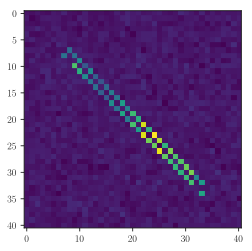

In [8]:
plt.imshow(np.log(model.predict(test_x[1000].reshape(1, -1)).reshape(2 * Imax + 1, 2 * Imax + 1)))
plt.show()

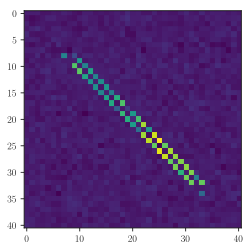

In [17]:
plt.imshow(np.log(model.predict(test_x[200].reshape(1, -1)).reshape(2 * Imax + 1, 2 * Imax + 1)))
plt.show()

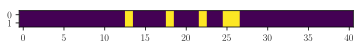

In [19]:
plt.imshow(np.vstack((np.array(test_x[200]), np.array(test_x[200]))))
plt.show()

In [ ]:
dsf_data = {}
already_explored = []
rstate = lls.lieb_liniger_state(1, L, N)
rstate.calculate_all()
current_state = map_to_entire_space(copy.copy(rstate.Is), Imax)
ffactors = []
for t in range(10000):
    print("t", t)
#     print(current_state)
    new_state = mutate(model, current_state, already_explored)
#     print("new_state", new_state)
    already_explored.append(list(current_state))
    lstate = lls.lieb_liniger_state(1, L, N, map_to_bethe_numbers(new_state, Imax))
    lstate.calculate_all()
    lstate.ff = rff.rho_form_factor(lstate, rstate)
#     print(lstate.ff)

    ffactors.append(lstate.ff)
    integer_momentum = lstate.integer_momentum
#     print(integer_momentum, lstate)
    if integer_momentum in dsf_data.keys():
        dsf_data[integer_momentum].append(lstate)
    else:
        dsf_data[integer_momentum] = [lstate]
#     print(dsf_data[integer_momentum])
    current_state = new_state


In [ ]:
# print(dsf_data)
print("sumrule", sum_rule.compute_average_sumrule(dsf_data, rstate.energy, L, N, Imax, 2 * Imax + 1))
# for z in dsf_data:
#     print(z, data[z], len(data[z]))
# print([map_to_bethe_numbers(k, 20) for k in already_explored])


In [ ]:
plt.semilogy(np.abs(np.array(ffactors)), 'ro', markersize=1)
plt.semilogy(np.sort(np.abs(np.array(ffactors)))[::-1])
plt.show()